# Dependencies & Init

In [1]:
!pip install pandas numpy matplotlib scikit-learn tensorflow plotly openai pyharmonics --upgrade

from pyharmonics.technicals import Technicals
from pyharmonics.search import HarmonicSearch
from pyharmonics.plotter import Plotter
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Conv1D, MaxPooling1D, Flatten, Bidirectional
from datetime import datetime as D
from tensorflow.keras.callbacks import EarlyStopping as E
from keras.losses import Huber as H
from plotly.subplots import make_subplots as m
from sklearn.preprocessing import MinMaxScaler as M
from openai import OpenAI as O
from tensorflow.keras.models import Sequential as S
import plotly.graph_objects as G
import matplotlib.pyplot as L
import numpy as N
import pandas as P
import requests as R

P.set_option('display.max_rows', None)
P.set_option('display.max_columns', None)
P.set_option('display.width', None)
P.set_option('display.max_colwidth', None)

def ts() -> P.DataFrame:
  t = P.DataFrame(R.get("https://www.okx.com/api/v5/market/candles",
    params={"instId": "BTC-USDT", "bar": "5m", "limit": "600"}).json()['data'],
    columns=["datetime", "open", "high", "low", "close", "volume", "currency_volume", "num_trades", "unknown"])
  t['date'] = P.to_datetime(t['datetime'].astype(int), unit='ms').dt.tz_localize('UTC').dt.tz_convert('Asia/Shanghai')
  t.set_index('date', inplace=True)
  for n in ["open", "high", "low", "close", "volume"]: t[n] = t[n].astype(float)
  t.drop(columns=['unknown'], inplace=True)
  return t[["open", "high", "low", "close", "volume"]]

def ne() -> str:
  t = R.get("https://cryptopanic.com/api/v1/posts/",
    params={"auth_token": "672fbfedfaefad4ffd717ce7f80a1e7c0e7a0b90", "currencies": "BTC,ETH"}).json()
  n = [f"{D.fromisoformat(ne['created_at']).strftime('%y-%m-%d %H:%M')} {ne['title']}"
    for ne in t.get("results", [])]
  return "\n".join(n)

def ma() -> str:
  t = R.get("https://www.okx.com/api/v5/market/books", params={"instId": "BTC-USDT", "sz": "50"}).json()['data'][0]
  n = "Bids:\n"
  for price, qty, *others in t['bids']: n += f"Price: {price}  Quantity: {qty}\n"
  n += "\nAsks:\n"
  for price, qty, *others in t['asks']: n += f"Price: {price}  Quantity: {qty}\n"
  return n

def se() -> str:
  t = R.get("https://api.alternative.me/fng/?limit=10&date_format=us").json()
  n = "date,fng_value,fng_classification\n"
  for i in t['data']: n += f"{i['timestamp']},{i['value']},{i['value_classification']}\n"
  return n

# print(ts())
# print(ne())
# print(ma())
# print(se())

  Using cached numpy-2.3.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (62 kB)


# LLM Predict

In [2]:
print(O(base_url="https://integrate.api.nvidia.com/v1",
  api_key='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').chat.completions.create(
  model='qwen/qwen3-235b-a22b',
  messages=[{"role": "system", "content":
"You are a master FX strategist and market analyst with deep knowledge of global macroeconomics, technical analysis, and risk management. Provide a concise trading plan based on the user's input, without offering detailed explanations."
}, {"role": "user", "content": f"""Analyze the following OHLC market price data,
formulate RSI, EMA, MACD, Bollinger Bands, Stochastic, ATR, Parabolic, Harmonics, Fibonacci, Gann,
and another other indicators that could be useful for prediction.
Together with the following news, market depth and market sentiment to give me real-time trading plan for the next 3 hours:

*Time Series*\n{ts().head(100)}

*Latest News*\n{ne()}

*Market Depth*\n{ma()}

*Market Sentiment*\n{se()}

Be bold in your prediction, I understand and will be responsible for all risk. Provide *only* the price prediction, *without* additional explanations or introductory text.
"""}],
  temperature=0.2,
  top_p=0.7,
  max_tokens=8192,
  extra_body={"chat_template_kwargs": {"thinking": False}},
  stream=False).choices[0].message.content)

**Price Prediction for the Next 3 Hours: 118,350 – 118,600**


# Plot charts

In [3]:
def rsi(s):
    n = s.diff()
    return 100 - (100 / (1 + (n.where(n > 0, 0)).rolling(window=14).mean() / (-n.where(n < 0, 0)).rolling(window=14).mean()))

t = ts()
t['EMA_200'] = t['close'].ewm(span=200, adjust=True).mean()
t['EMA_50'] = t['close'].ewm(span=50, adjust=True).mean()
t['SMA_20'] = t['close'].rolling(window=20).mean()
t['STD_20'] = t['close'].rolling(window=20).std()
t['Upper_Band'] = t['SMA_20'] + (t['STD_20'] * 2)
t['Lower_Band'] = t['SMA_20'] - (t['STD_20'] * 2)
t['Middle_Band'] = t['SMA_20']
t['RSI_14'] = rsi(t['close'])
t['MACD'] = t['close'].ewm(span=12, adjust=True).mean() - t['close'].ewm(span=26, adjust=True).mean()
t['Signal_Line'] = t['MACD'].ewm(span=9, adjust=True).mean()
t['MACD_Histogram'] = t['MACD'] - t['Signal_Line']
t['Volume_SMA_20'] = t['volume'].rolling(window=20).mean()
n = t['low'].rolling(window=14).min()
t['%K'] = 100 * ((t['close'] - n) / (t['high'].rolling(window=14).max() - n))
t['%D'] = t['%K'].rolling(window=3).mean()
t['Support'] = t['low'].rolling(window=20).min()
t['Resistance'] = t['high'].rolling(window=20).max()

# Main chart
f = G.Figure(data=[G.Candlestick(x=t.index, open=t['open'], high=t['high'], low=t['low'], close=t['close'])])
f.add_trace(G.Scatter(x=t.index, y=t['EMA_200'], mode='lines', name='EMA 200'))
f.add_trace(G.Scatter(x=t.index, y=t['EMA_50'], mode='lines', name='EMA 50'))
f.add_trace(G.Scatter(x=t.index, y=t['Upper_Band'], mode='lines', name='Upper Band', line=dict(color='orange', dash='dash')))
f.add_trace(G.Scatter(x=t.index, y=t['Middle_Band'], mode='lines', name='Middle Band', line=dict(color='orange')))
f.add_trace(G.Scatter(x=t.index, y=t['Lower_Band'], mode='lines', name='Lower Band', line=dict(color='orange', dash='dash')))
f.add_trace(G.Scatter(x=t.index, y=t['Support'], mode='lines', name='Support', line=dict(color='green', dash='dot')))
f.add_trace(G.Scatter(x=t.index, y=t['Resistance'], mode='lines', name='Resistance', line=dict(color='red', dash='dot')))
f.update_layout(title='BTCUSD', xaxis_rangeslider_visible=False)
f.show()

# Harmonic chart
n = Technicals(t.reset_index(), symbol='BTCUSD', interval='5m')
h = HarmonicSearch(n)
p = Plotter(n)
p.add_harmonic_plots(h.get_patterns())
p.show()
h.forming()
p.add_harmonic_plots(h.get_patterns(formed=False))
p.show()

# RSI chart
f = G.Figure()
f.add_trace(G.Scatter(x=t.index, y=t['RSI_14'], mode='lines', name='RSI (14)'))
f.add_shape(type='line', x0=t.index.min(), x1=t.index.max(), y0=70, y1=70, line=dict(color='Red', dash='dash'))
f.add_shape(type='line', x0=t.index.min(), x1=t.index.max(), y0=30, y1=30, line=dict(color='Green', dash='dash'))
f.update_layout(title='RSI (14)')
f.show()

# MACD chart
f = G.Figure()
f.add_trace(G.Scatter(x=t.index, y=t['MACD'], mode='lines', name='MACD Line', line=dict(color='blue')))
f.add_trace(G.Scatter(x=t.index, y=t['Signal_Line'], mode='lines', name='Signal Line', line=dict(color='red')))
f.add_trace(G.Bar(x=t.index, y=t['MACD_Histogram'], name='Histogram', marker=dict(color='grey')))
f.update_layout(title='MACD')
f.show()

# Volume chart
f = G.Figure()
f.add_trace(G.Bar(x=t.index, y=t['volume'], name='Volume', marker=dict(color='blue', opacity=0.5)))
f.add_trace(G.Scatter(x=t.index, y=t['Volume_SMA_20'], mode='lines', name='Volume SMA (20)', line=dict(color='red')))
f.update_layout(title='Volume with SMA (20)')
f.show()

# Stochastic
f = G.Figure()
f.add_trace(G.Scatter(x=t.index, y=t['%K'], mode='lines', name='%K Line', line=dict(color='blue')))
f.add_trace(G.Scatter(x=t.index, y=t['%D'], mode='lines', name='%D Line', line=dict(color='red')))
f.add_shape(type='line', x0=t.index.min(), x1=t.index.max(), y0=80, y1=80, line=dict(color='Red', dash='dash'))
f.add_shape(type='line', x0=t.index.min(), x1=t.index.max(), y0=20, y1=20, line=dict(color='Green', dash='dash'))
f.update_layout(title='Stochastic Oscillator')
f.show()

# Feature selection & Sequence creation
f = t[['close', 'volume', 'EMA_200', 'EMA_50', 'RSI_14', 'SMA_20', 'STD_20',
       'Upper_Band', 'Lower_Band', 'Middle_Band', 'MACD', 'Signal_Line',
       'MACD_Histogram', 'Volume_SMA_20', '%K', '%D']].dropna()
c, l, X, y = M(), 60, [], []
d = c.fit_transform(f)
for i in range(l, len(d)):
    X.append(d[i-l:i])
    y.append(d[i, 0])
X, y = N.array(X), N.array(y)

# LSTM Predict

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - loss: 0.0416 - val_loss: 0.0014
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0062 - val_loss: 0.0017
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0062 - val_loss: 1.0731e-04
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0049 - val_loss: 8.3893e-04
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0055 - val_loss: 0.0012
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0043 - val_loss: 1.5573e-04
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0050 - val_loss: 1.3208e-04
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0033 - val_loss: 7.5444e-05
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0036 - val_loss: 8.7115e-05
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0024 - val_loss: 7.6148e-05
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


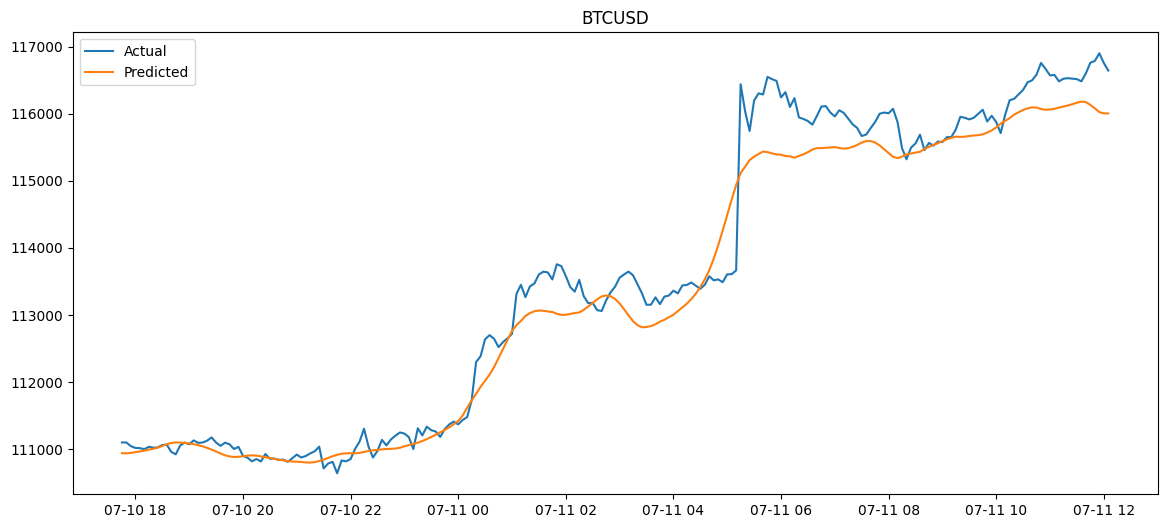

ValueError: non-broadcastable output operand with shape (1,1) doesn't match the broadcast shape (1,16)

In [4]:
# LSTM Model
m = S()
m.add(Input(shape=(X.shape[1], X.shape[2])))
m.add(LSTM(164, return_sequences=True))
m.add(Dropout(0.2))
m.add(LSTM(32))
m.add(Dropout(0.2))
m.add(Dense(16, activation='relu'))
m.add(Dense(1))

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
m.compile(optimizer=optimizer, loss='mse')

m.compile(optimizer='adam', loss=H())
m.fit(X, y, epochs=10, batch_size=32, validation_split=0.1, callbacks=[E(monitor='val_loss', patience=7, restore_best_weights=True)])

# Plot
e = f.index[-len(y):]
L.figure(figsize=(14, 6))
L.plot(e, c.inverse_transform(N.hstack((y.reshape(-1, 1), N.zeros((len(y), f.shape[1] - 1)))))[:, 0], label='Actual')
L.plot(e, c.inverse_transform(N.hstack((m.predict(X), N.zeros((len(y), f.shape[1] - 1)))))[:, 0], label='Predicted')
L.title('BTCUSD')
L.legend()
L.show()

# # Predict 10 future steps
# u = []
# v = d[-l:].copy()
# for _ in range(10):
#   p = m(N.expand_dims(v, axis=0), training=False).numpy()[0]
#   u.append(p[0])
#   v = N.vstack((v[1:], N.hstack((p, v[-1, 1:]))))

# # Plot forecast extension
# o = c.inverse_transform(N.hstack((N.array(u).reshape(-1, 1), N.zeros((10, f.shape[1] - 1)))))[:, 0]
# print("Future Forecast:", [float(x) for x in o])
# L.figure(figsize=(14, 6))
# L.plot(t.index[-100:], t['close'].iloc[-100:], label='Recent Close Prices (from t)')
# L.plot([f.index[-1] + P.Timedelta(minutes=5 * (i+1)) for i in range(10)], o, marker='o', linestyle='--', label='Forecast')
# L.title('BTCUSD 10-Step')
# L.legend()
# L.show()

from sklearn.preprocessing import MinMaxScaler

# Create separate scalers
price_scaler = MinMaxScaler()
feature_scaler = MinMaxScaler()

# Fit them separately
price_scaler.fit(t[['close']])  # Only close price
feature_scaler.fit(t.drop('close', axis=1))  # All other features

# Then in your prediction function:
def make_prediction(model, price_scaler, recent_data, sequence_length):
    if len(recent_data) < sequence_length:
        return None

    last_sequence = recent_data[-sequence_length:]
    prediction_input = N.expand_dims(last_sequence, axis=0)
    prediction = model.predict(prediction_input, verbose=0)

    # Clean inverse transform - no warning
    pred_price = price_scaler.inverse_transform(prediction)[0, 0]

    return pred_price

def predict_future_steps(model, scaler, recent_data, sequence_length, steps=10):
    predictions = []
    current_sequence = recent_data[-sequence_length:].copy()

    for step in range(steps):
        pred_price = make_prediction(model, scaler, current_sequence, sequence_length)

        if pred_price is None:
            break

        predictions.append(pred_price)

        new_row = current_sequence[-1].copy()
        new_row[0] = scaler.transform(N.array([[pred_price] + [0] * (current_sequence.shape[1] - 1)]))[0, 0]
        current_sequence = N.vstack((current_sequence[1:], new_row))

    return N.array(predictions)

# Predict 10 future steps
future_predictions = predict_future_steps(m, c, d, l, steps=10)

# **KEY FIX: Use the actual current time from your raw data**
current_time = t.index[-1]  # Use the last timestamp from your raw data 't'

# Create future timestamps starting from the ACTUAL current time
future_times = [current_time + P.Timedelta(minutes=5 * (i+1)) for i in range(len(future_predictions))]

# Plot forecast extension
L.figure(figsize=(14, 6))
L.plot(t.index[-100:], t['close'].iloc[-100:], label='Recent Close Prices (from t)')

# Add a connection line from current price to first prediction
L.plot([current_time, future_times[0]], [t['close'].iloc[-1], future_predictions[0]],
       color='orange', linestyle=':', alpha=0.5)

L.plot(future_times, future_predictions, marker='o', linestyle='--', label='Forecast', color='orange')

L.title('BTCUSD 10-Step Forecast')
L.legend()
L.show()

print("Future Forecast:", [float(x) for x in future_predictions])

# CNN Prediction

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 334ms/step - loss: 0.5063 - val_loss: 0.0208
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0704 - val_loss: 0.0167
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0218 - val_loss: 0.0040
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0132 - val_loss: 2.3991e-04
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0067 - val_loss: 0.0029
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0067 - val_loss: 0.0011
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0081 - val_loss: 0.0014
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0058 - val_loss: 0.0013
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0053 - val_loss: 8.1796e-04
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


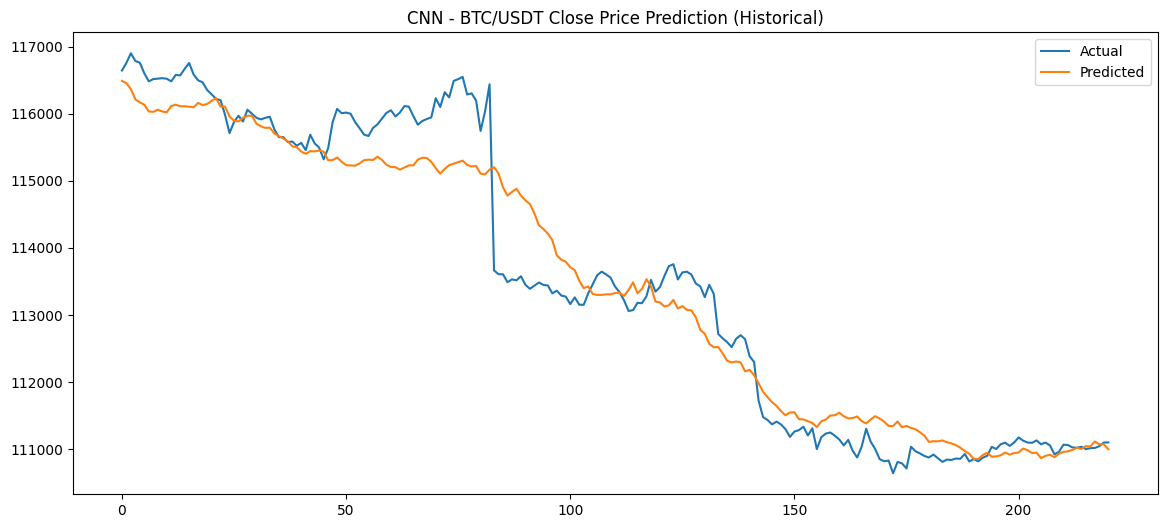

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predictions:  [111001.35, 111029.2, 111044.41, 111054.71, 111053.26, 111076.37, 111060.0, 111048.78, 111030.97, 111078.71]


In [5]:
# CNN model
m = S()
m.add(Input(shape=(X.shape[1], X.shape[2])))
m.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
m.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
m.add(MaxPooling1D(pool_size=2))
m.add(Dropout(0.2))
m.add(Flatten())
m.add(Dense(64, activation='relu'))
m.add(Dense(1))
m.compile(optimizer='adam', loss='mean_squared_error')
m.fit(X, y, epochs=50, batch_size=32, validation_split=0.1, callbacks=[E(monitor='val_loss', patience=5, restore_best_weights=True)])

# Plot Historical Prediction vs Actual
p = m.predict(X)
L.figure(figsize=(14, 6))
L.plot(c.inverse_transform(N.hstack((y.reshape(-1, 1), N.zeros((len(y), f.shape[1] - 1)))))[:, 0], label='Actual')
L.plot(c.inverse_transform(N.hstack((p, N.zeros((len(p), f.shape[1] - 1)))))[:, 0], label='Predicted')
L.title('CNN - BTC/USDT Close Price Prediction (Historical)')
L.legend()
L.show()

# Prediction
u, l = [], X[-1]
for _ in range(10):
  n = m.predict(N.expand_dims(l, axis=0))[0]
  u.append(c.inverse_transform([N.hstack((n, N.zeros(f.shape[1] - 1)))])[0, 0])
  l = N.vstack((l[1:], N.hstack((n, l[-1, 1:]))))
print("Predictions: ", [round(float(p), 2) for p in u])

In [ ]:
from datetime import datetime

# Date then to now
start_date = datetime(2025, 7, 10)
end_date = datetime(2029, 12, 31)

# number of transactions x the number of days
days_difference = 14547908* (end_date - start_date).days
print(days_difference)

23785829580
